In [1]:
!pip install -q bertopic
!pip install -q pymystem3
import numpy as np
import pandas as pd
from bertopic import BERTopic
import re
import nltk
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
import matplotlib.pyplot as plt
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.manifold import TSNE
from sklearn.cluster import Birch
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

2024-08-01 05:11:34.456590: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-01 05:11:34.456711: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-01 05:11:34.593809: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [233]:
from nltk.tokenize import sent_tokenize, word_tokenize
from transformers import AutoTokenizer, AutoModel
import torch
from PIL import Image

In [5]:
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
corpus_dir = '/kaggle/input/glowbytedataset/Crime And Punishment.txt'

In [191]:
character_set = "[!#$%&'()*+,./:;<=>?@[\]^_`{|}„“~—\"\-]–+«»…"
stopwords_ru = set(stopwords.words("russian")+ ["это", "твой","свой","всё", "который", "ещё"])

In [90]:
def is_match(regex, text):
    pattern = re.compile(regex)
    return pattern.search(text) is not None

In [194]:
with open(corpus_dir) as f:
    lines = f.readlines()

In [195]:
seq_sentences = []
for line in lines:
    if line == '\n':
        continue
    else:
        for l in line.split('\n'):
            if is_match('[\\*A-Za-z]',l):
                continue
            else:
                for seq in l.split('.'):
                    seq_sentences.append(seq)

In [211]:
mystem = Mystem()
def preprocess_text(text):
    text = [c for c in text if c not in character_set]
    text = ''.join(text)
    
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in stop_words\
              and token != " " and token.strip() not in punctuation]
    
    text = " ".join(tokens)
    
    return text

In [212]:
df = pd.DataFrame(seq_sentences,columns=['text'])
df['clean_text'] = df['text'].apply(preprocess_text)
df = df.drop(df[df['clean_text'].str.len() <= 2].index).reset_index(drop=True)

In [125]:
# df = pd.DataFrame(seq_sentences,columns=['text'])
# df['clean_text'] = df['text'].apply(preprocess_text)
# df = df.drop(df[df['clean_text'].str.len() <= 2].index).reset_index(drop=True)

## Embedding visualization 

In [237]:
from transformers import AutoTokenizer, AutoModel
import torch

In [238]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [239]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [277]:
tokenizer = AutoTokenizer.from_pretrained("ai-forever/sbert_large_mt_nlu_ru")
model = AutoModel.from_pretrained("ai-forever/sbert_large_mt_nlu_ru")
model.to(device)
encoded_input = tokenizer(df['clean_text'].to_list(), padding=True, truncation=True, max_length=24, return_tensors='pt')

In [36]:
# torch.cuda.empty_cache()
# import gc
# gc.collect()

0

In [278]:
model_output = []
model.eval()
with torch.no_grad():
    for ids,mask,token_type in zip(encoded_input['input_ids'],encoded_input['attention_mask'],encoded_input['token_type_ids']):
        ids = ids.to(device).unsqueeze(dim=0)
        token_type = token_type.to(device).unsqueeze(dim=0)
        mask = mask.to(device).unsqueeze(dim=0)
        out = model(ids,mask,token_type)
        model_output.append(mean_pooling(out,mask))
model_output = torch.cat(model_output)
model_output = model_output.cpu().numpy()

In [279]:
umap_model = UMAP(n_neighbors=15, n_components=3, 
                  min_dist=0.0, metric='cosine', random_state=42)

In [280]:
mo = umap_model.fit_transform(model_output)

In [281]:
def plot_embeddings(text_corpus):
    '''3д визуализация векторизации предложений'''
    fig = plt.figure(figsize = [10,10])
    ax = fig.add_subplot(projection='3d')
    scatter = ax.scatter(text_corpus[:,0],text_corpus[:,1],text_corpus[:,2])
    plt.show()

Визуализация ебмеддинга без кластеризации.

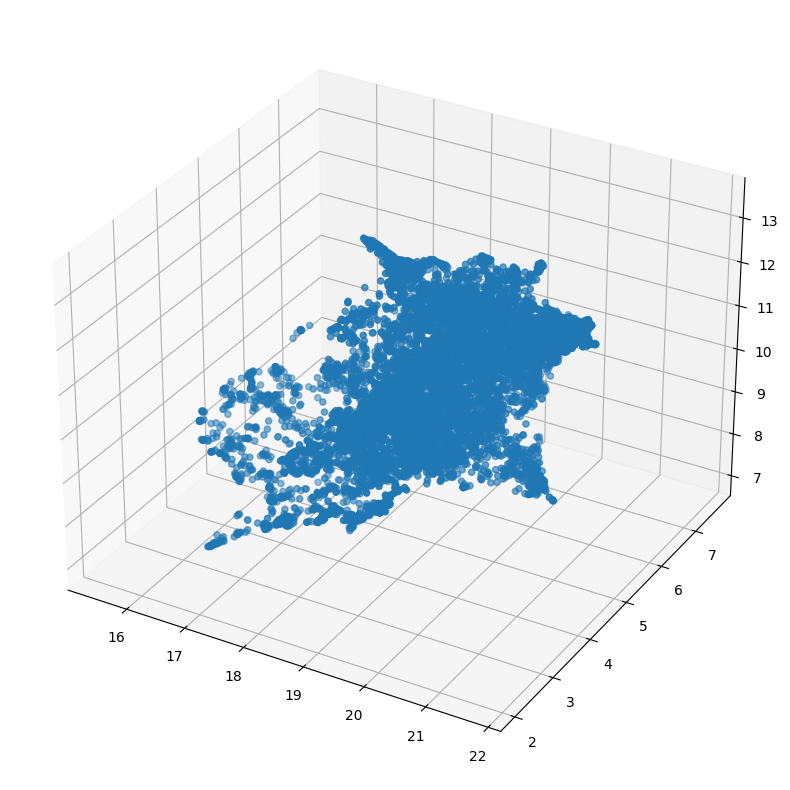

In [282]:
plot_embeddings(mo)

In [270]:
sentence_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
clean_text = df['clean_text'].to_list()
embeddings = sentence_model.encode(clean_text, show_progress_bar=False)
topic_model = BERTopic().fit(clean_text, embeddings)
reduced_embeddings = UMAP(n_neighbors=20, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)

uncomment plots when run notebook

In [328]:
#topic_model.visualize_documents(clean_text, reduced_embeddings=reduced_embeddings)

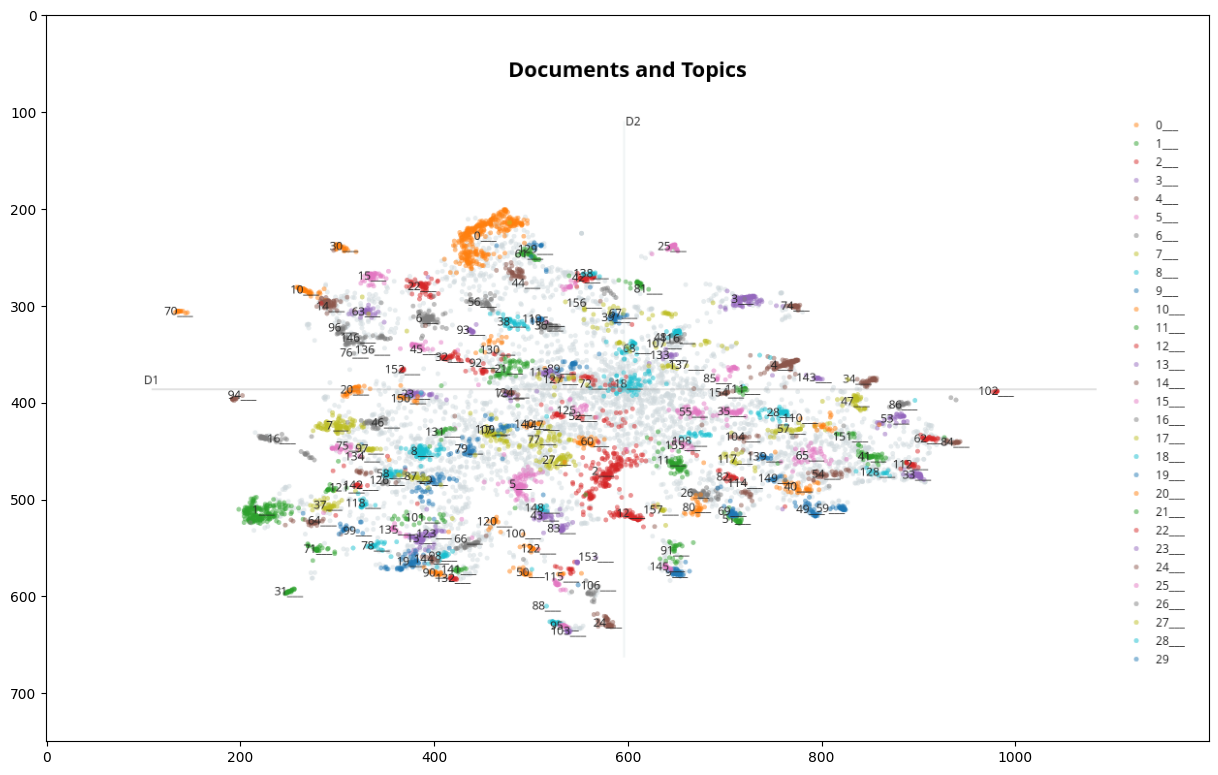

In [302]:
plt.figure(figsize = (15,15))
plt.imshow(Image.open('/kaggle/input/glowbytedataset/fig1.png'))
plt.show()

In [33]:
# fig = topic_model.visualize_documents(clean_text, reduced_embeddings=reduced_embeddings)
# fig.write_html("/kaggle/working/file.html")

## Clustering and visualization

In [19]:
topic_model = BERTopic(language='multilingual', calculate_probabilities=True,verbose=False,min_topic_size = 15,n_gram_range = (1,3))
topics,probs = topic_model.fit_transform(df['clean_text'])

In [20]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,3862,-1_это_весь_свой_мочь,"[это, весь, свой, мочь, сказать, раскольников,...",[милостивый государь милостивый государь воскл...
1,0,353,0_петрович_петр петрович_петр_порфирий петрович,"[петрович, петр петрович, петр, порфирий петро...","[петр петрович рассердиться, петр петрович взд..."
2,1,189,1_соня_спать_сон_просыпаться,"[соня, спать, сон, просыпаться, ночь, час, сон...",[думать весь сон странный разный сон нечего го...
3,2,172,2_разумихин_зосимов_крикнуть разумихин_разумих...,"[разумихин, зосимов, крикнуть разумихин, разум...",[попадать попадать вскричать разумихин неужели...
4,3,144,3_лебезятник_катерина_катерина ивановна_миколка,"[лебезятник, катерина, катерина ивановна, мико...",[странный дело большой телега впрягать маленьк...
...,...,...,...,...,...
106,105,17,105_черточка_глупо_глупость_черта,"[черточка, глупо, глупость, черта, эх глупость...","[экий наивный дурак, эх глупость сморозить, фу..."
107,106,17,106_стол_стол стоять_стоять_посматривать кругом,"[стол, стол стоять, стоять, посматривать круго...",[снимать полагать фуражка стол минута десять с...
108,107,16,107_картофель_кутья_блюдо_пирог,"[картофель, кутья, блюдо, пирог, ложка, кухня,...",[например обжора клубный гастроном мочь ткнуть...
109,108,15,108_жить_оставаться_жить жить_весь жизнь,"[жить, оставаться, жить жить, весь жизнь, полу...","[знать знать последовать знать жить жить, б во..."


In [327]:
#topic_model.visualize_topics()

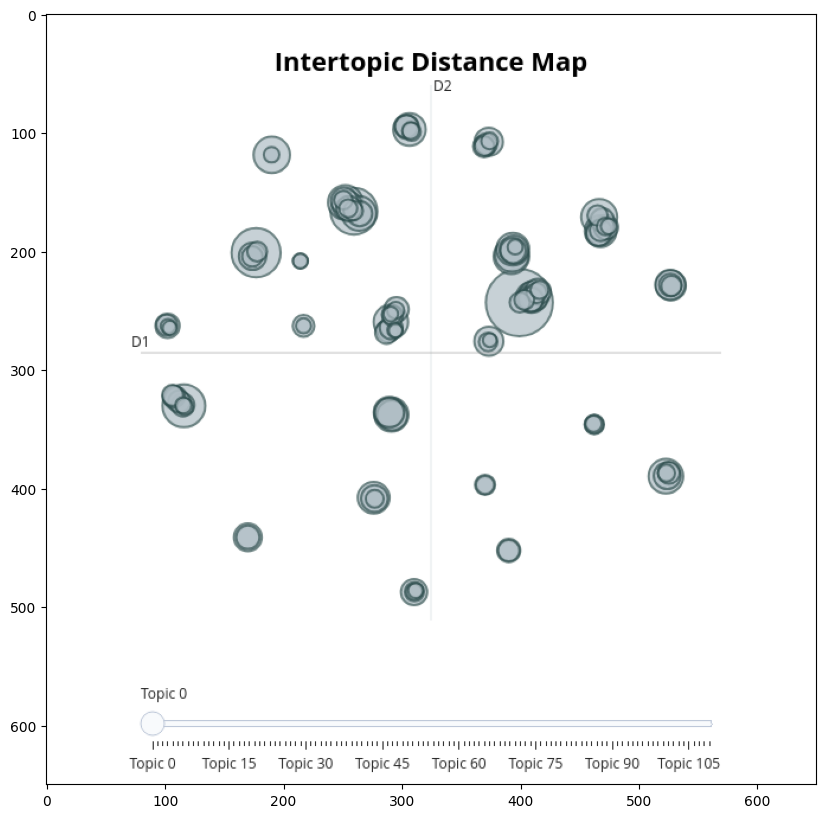

In [304]:
plt.figure(figsize = (10,10))
plt.imshow(Image.open('/kaggle/input/glowbytedataset/fig2.png'))
plt.show()

In [326]:
#topic_model.visualize_barchart(top_n_topics=6)

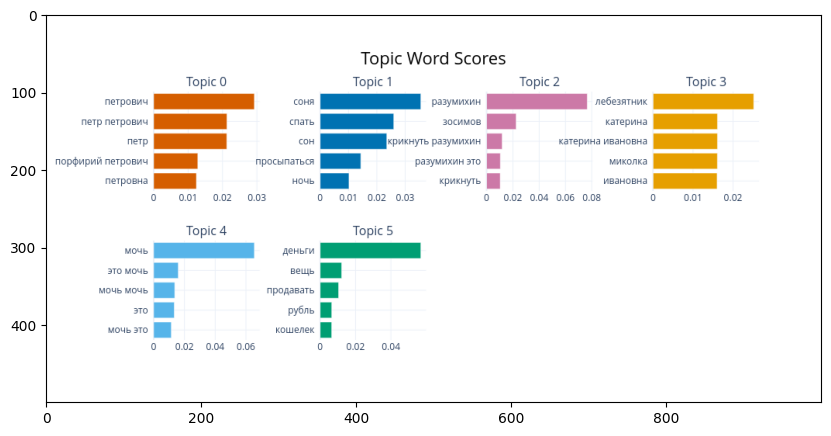

In [305]:
plt.figure(figsize = (10,10))
plt.imshow(Image.open('/kaggle/input/glowbytedataset/fig3.png'))
plt.show()

In [325]:
#topic_model.visualize_hierarchy(top_n_topics=30)

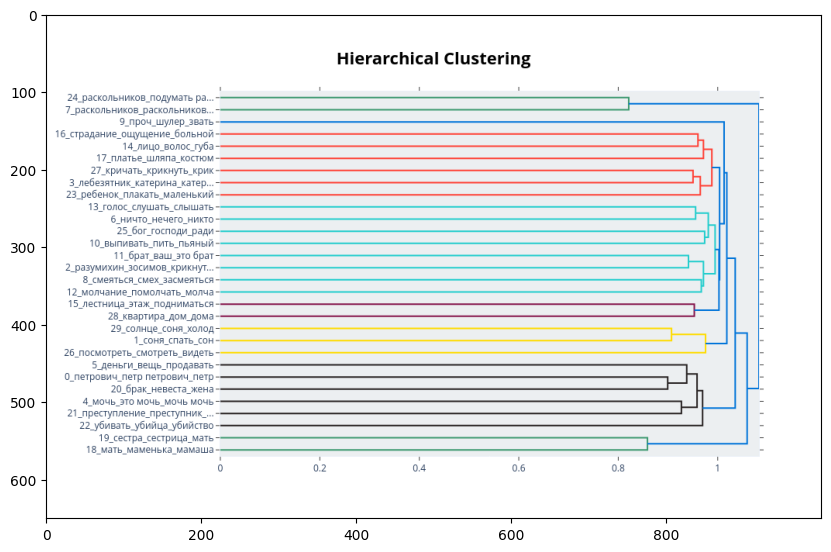

In [306]:
plt.figure(figsize = (10,10))
plt.imshow(Image.open('/kaggle/input/glowbytedataset/fig4.png'))
plt.show()

### Using SberBert model for embeddings

In [265]:
embedding_model = SentenceTransformer("ai-forever/sbert_large_mt_nlu_ru",)
#embedding_model = SentenceTransformer('ai-forever/ru-scibench-oecd-clustering-p2p')

In [268]:
topic_model = BERTopic(embedding_model = embedding_model, calculate_probabilities=True,verbose=False,min_topic_size = 15,n_gram_range = (1,3))
topics,probs = topic_model.fit_transform(df['clean_text'])

In [269]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,5148,-1_это_весь_мочь_свой,"[это, весь, мочь, свой, говорить, человек, ста...","[это говорить, это, это]"
1,0,529,0_раскольников_раскольник_раскольников расколь...,"[раскольников, раскольник, раскольников раскол...","[отвечать раскольников, раскольников, раскольн..."
2,1,316,1_весь_это_свой_минута,"[весь, это, свой, минута, время, мочь, человек...",[минута состояние правильный видеть рассуждать...
3,2,247,2_деньги_рубль_пять_вещь,"[деньги, рубль, пять, вещь, карман, двадцать, ...",[узнавать несколько месяц оставлять университе...
4,3,171,3_пойти_полиция_контора_пойти пойти,"[пойти, полиция, контора, пойти пойти, шулер, ...","[пойти, пойти, пойти]"
...,...,...,...,...,...
62,61,20,61_час_час час_час этак_час час час,"[час, час час, час этак, час час час, одиннадц...",[приходить вечер становиться проходить весь ча...
63,62,18,62_свидригайлов_расхохотаться_свидригайлов сид...,"[свидригайлов, расхохотаться, свидригайлов сид...",[свидригайлов подымать голова пристально посмо...
64,63,17,63_завтра_сегодня_вчера_поговорить таковыто ясный,"[завтра, сегодня, вчера, поговорить таковыто я...","[завтра, завтра утро дело приходить слово сказ..."
65,64,17,64_спать_спать вскричать_спать спать_час шесть,"[спать, спать вскричать, спать спать, час шест...",[ах боже верить весь ночь спать вскричать бедн...


### Euclidian distance

По умолчанию BertTopic исползует HDBSCAN,который в свою очередь использует евклидово расстояние, как метрику расстояния


In [ ]:
from bertopic.representation import MaximalMarginalRelevance

In [ ]:
representation_model = MaximalMarginalRelevance() # улучшаем названия топиков
umap_model = UMAP(n_neighbors=15, n_components=5, 
                  min_dist=0.0, metric='cosine', random_state=42) # фиксируем рандом для проведения эксперемента

In [34]:
topic_model_euclidian = BERTopic(embedding_model = embedding_model,
                       calculate_probabilities=True,
                       verbose=False,
                       min_topic_size = 15,
                       n_gram_range = (1,3),
                       representation_model=representation_model,
                       umap_model = umap_model
                      )
topics,probs = topic_model_euclidian.fit_transform(df['clean_text'])
topic_model_euclidian.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,4989,-1_мочь_сказать_дело_петрович,"[мочь, сказать, дело, петрович, разумихин, вид...",[думать весь сон странный разный сон нечего го...
1,0,533,0_раскольников_раскольников раскольников_прого...,"[раскольников, раскольников раскольников, прог...","[раскольников выходить, отвечать раскольников,..."
2,1,373,1_дверь_этаж_входить_отворять,"[дверь, этаж, входить, отворять, запирать, окн...","[стоять дверь, лестница, дверь]"
3,2,262,2_деньги_рубль_двадцать_билет,"[деньги, рубль, двадцать, билет, получать, кар...","[деньги двадцать пять рубль, вопервых рубашка ..."
4,3,188,3_соня соня_прошептать соня_вскрикивать соня_с...,"[соня соня, прошептать соня, вскрикивать соня,...","[пойти соня, соня молчать, прошептать соня]"
...,...,...,...,...,...
70,69,17,69_придумывать нус_прелюбопытный эпизод которы...,"[придумывать нус, прелюбопытный эпизод который...",[счет мочь рассказывать прелюбопытный эпизод к...
71,70,17,70_час_ожиданиито хороший выходить_нетерпение ...,"[час, ожиданиито хороший выходить, нетерпение ...",[авдотья романовна пристально вглядываться бра...
72,71,17,71_свидригайлов подымать_свидригайлов свидрига...,"[свидригайлов подымать, свидригайлов свидригай...","[брать роль судья это сюрприз брат, свидригайл..."
73,72,16,72_марфа петровна_петр петрович_донос_александ...,"[марфа петровна, петр петрович, донос, алексан...",[ваш нумер правый родион давеча ваш петр петро...


In [324]:
#topic_model_euclidian.visualize_barchart(top_n_topics=6)

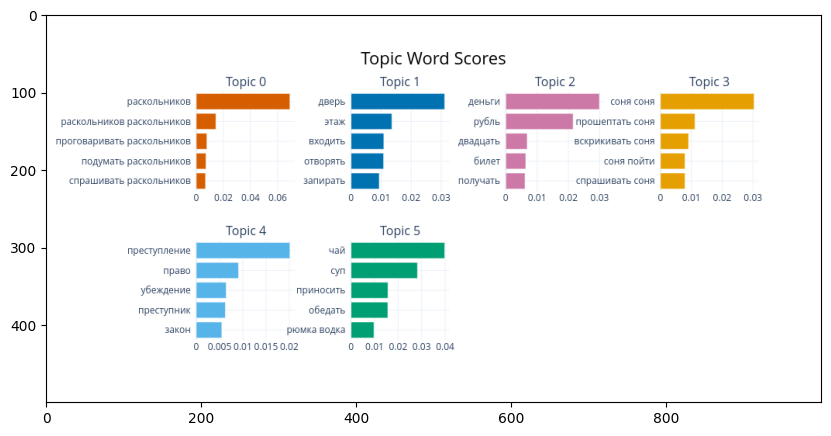

In [307]:
plt.figure(figsize = (10,10))
plt.imshow(Image.open('/kaggle/input/glowbytedataset/fig5.png'))
plt.show()

In [323]:
#topic_model_euclidian.visualize_topics()

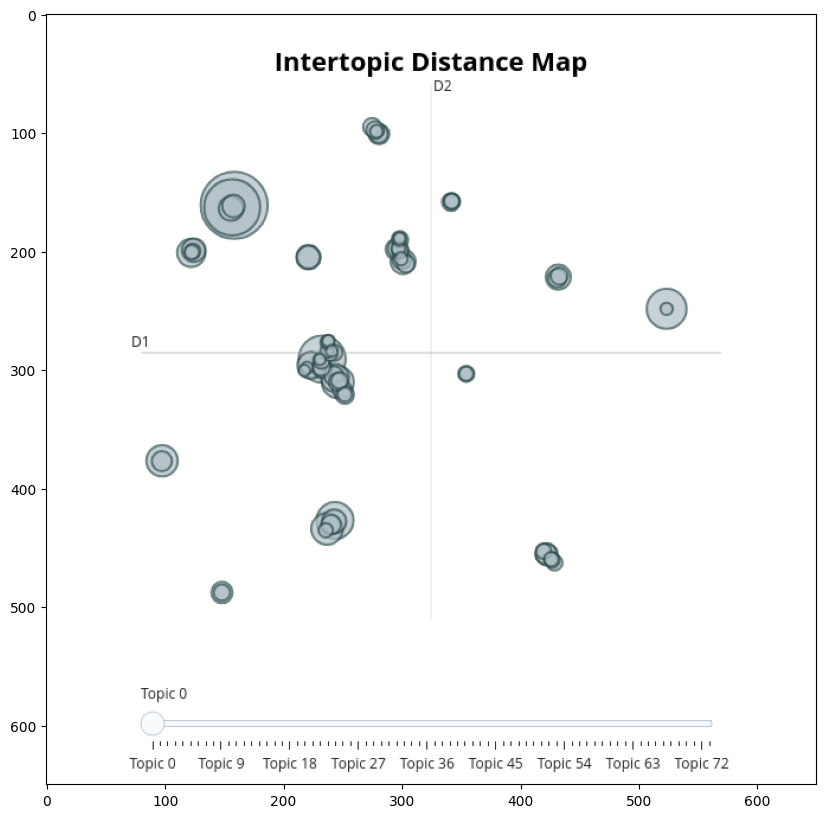

In [308]:
plt.figure(figsize = (10,10))
plt.imshow(Image.open('/kaggle/input/glowbytedataset/fig6.png'))
plt.show()

In [322]:
#topic_model_euclidian.visualize_hierarchy(top_n_topics=30)

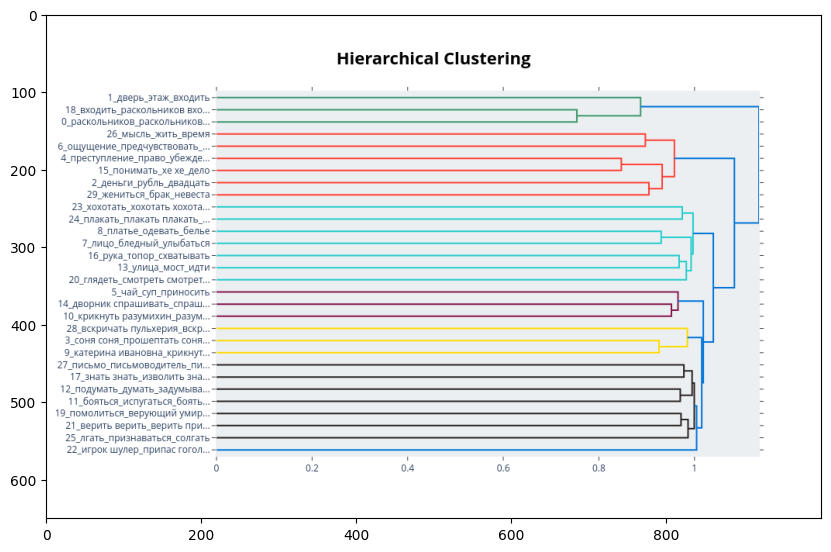

In [309]:
plt.figure(figsize = (10,10))
plt.imshow(Image.open('/kaggle/input/glowbytedataset/fig7.png'))
plt.show()

In [38]:
# from wordcloud import WordCloud
# import matplotlib.pyplot as plt

# def create_wordcloud(model, topic):
#     text = {word: value for word, value in model.get_topic(topic)}
#     wc = WordCloud(background_color="white", max_words=1000)
#     wc.generate_from_frequencies(text)
#     plt.imshow(wc, interpolation="bilinear")
#     plt.axis("off")
#     plt.show()

# # Show wordcloud
# create_wordcloud(topic_model, topic=1)

### Manhattan distance

In [60]:
bscan_model = HDBSCAN(min_cluster_size=15, metric='manhattan', cluster_selection_method='eom', prediction_data=True)

In [61]:
topic_model_manhattan = BERTopic(embedding_model = embedding_model,
                       calculate_probabilities=True,
                       verbose=False,
                       min_topic_size = 15,
                       n_gram_range = (1,3),
                       representation_model=representation_model,
                       umap_model = umap_model,
                       hdbscan_model = bscan_model,
                      )

In [62]:
topics,probs = topic_model_manhattan.fit_transform(df['clean_text'])

In [63]:
topic_model_manhattan.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,4902,-1_мочь_сказать_дело_петрович,"[мочь, сказать, дело, петрович, разумихин, вид...",[опасаться разливаться ночь желчь однако сторо...
1,0,543,0_раскольников_раскольников раскольников_прого...,"[раскольников, раскольников раскольников, прог...","[раскольников, раскольников, раскольников]"
2,1,339,1_дверь_отворять_входить_запирать,"[дверь, отворять, входить, запирать, ключ, про...",[знать отчего дверь запирать сюда входить двер...
3,2,318,2_пойти_шулер_нус_игрок,"[пойти, шулер, нус, игрок, этос, пойти пойти, ...","[пойти, пойти, пойти]"
4,3,270,3_соня соня_сон_соня это_прошептать соня,"[соня соня, сон, соня это, прошептать соня, вс...","[соня, соня, соня]"
...,...,...,...,...,...
60,59,18,59_вставать свидригайлов_свидригайлов застрели...,"[вставать свидригайлов, свидригайлов застрелив...","[брать роль судья это сюрприз брат, свидригайл..."
61,60,18,60_марфа петровна_марфа петровна который_петро...,"[марфа петровна, марфа петровна который, петро...",[мочь представлять весь страдание оставлять ме...
62,61,18,61_семомс завтра протяжно_ясный день приходите...,"[семомс завтра протяжно, ясный день приходитет...","[завтра, завтра утро дело приходить слово сказ..."
63,62,18,62_брат_разлука_свидание брат_родя,"[брат, разлука, свидание брат, родя, целовать,...",[ах болезнь чтото чтото говорить дуня сказать ...


In [321]:
#topic_model_manhattan.visualize_topics()

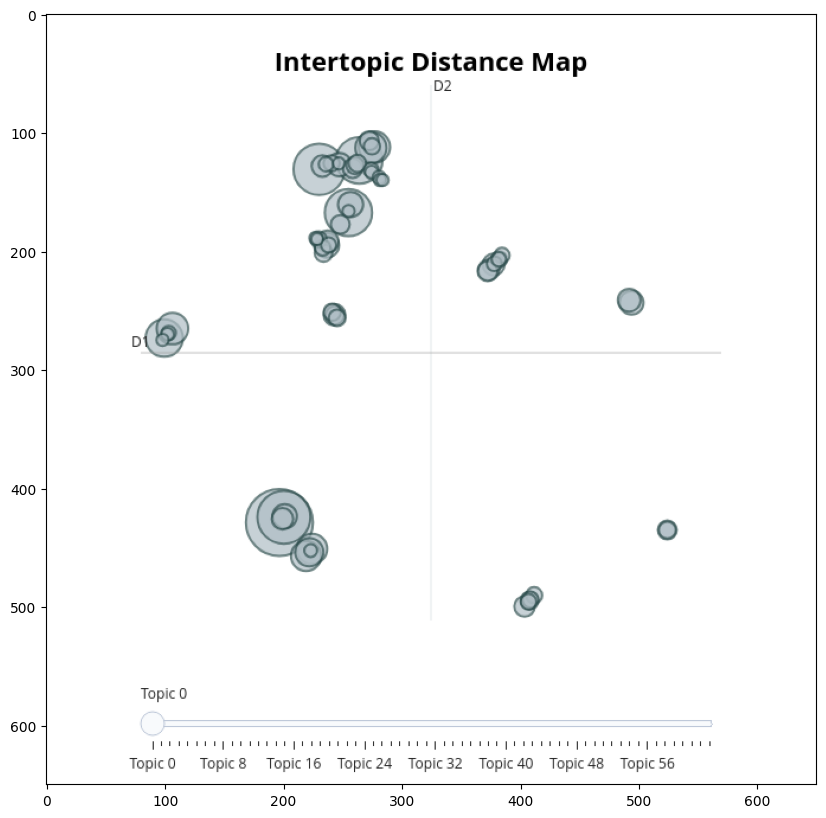

In [310]:
plt.figure(figsize = (10,10))
plt.imshow(Image.open('/kaggle/input/glowbytedataset/fig8.png'))
plt.show()

In [67]:
sim_matrix = cosine_similarity(topic_model_euclidian.topic_embeddings_, topic_model_manhattan.topic_embeddings_)

In [70]:
topic = 4
topic_model_euclidian.get_topic(4)

[('преступление', 0.02013495607826599),
 ('право', 0.009068748577117137),
 ('убеждение', 0.0064214679344942556),
 ('преступник', 0.006241586386888272),
 ('закон', 0.005475269326480678),
 ('случай', 0.005169430996956822),
 ('обыск', 0.004989529033870682),
 ('дело', 0.004856855741726661),
 ('нравственный', 0.004562724438733898),
 ('совесть', 0.004322751173194931)]

In [79]:
most_similar_topic = np.argmax(sim_matrix[topic + 1])-1
most_similar_topic

6

In [78]:
topic_model_manhattan.get_topic(most_similar_topic)

[('преступление', 0.025126938117663578),
 ('преступник', 0.011911728121736756),
 ('иметь право', 0.007400185246839158),
 ('дело', 0.00721752562394201),
 ('обыск', 0.006647384306880115),
 ('совесть', 0.005779414632747866),
 ('убеждение', 0.005376582341093086),
 ('обстоятельство', 0.004877983818021771),
 ('закон', 0.004873472023268965),
 ('случай', 0.0046654713173305065)]

In [320]:
#topic_model_manhattan.visualize_barchart(top_n_topics=8)

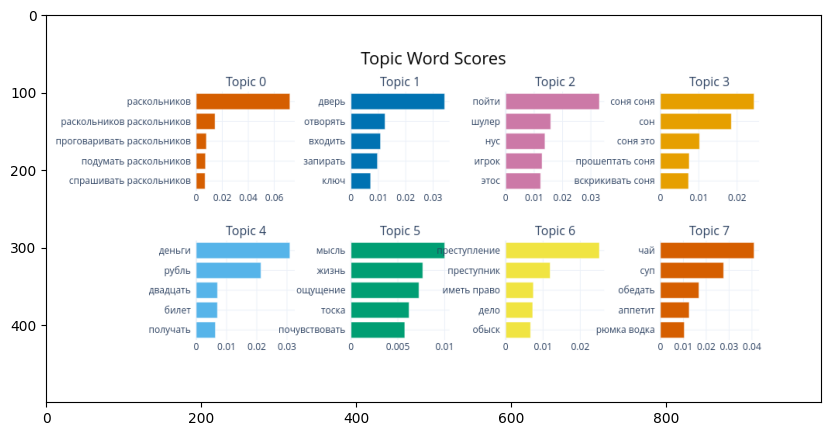

In [311]:
plt.figure(figsize = (10,10))
plt.imshow(Image.open('/kaggle/input/glowbytedataset/fig9.png'))
plt.show()

In [319]:
#topic_model_manhattan.visualize_hierarchy(top_n_topics=30)

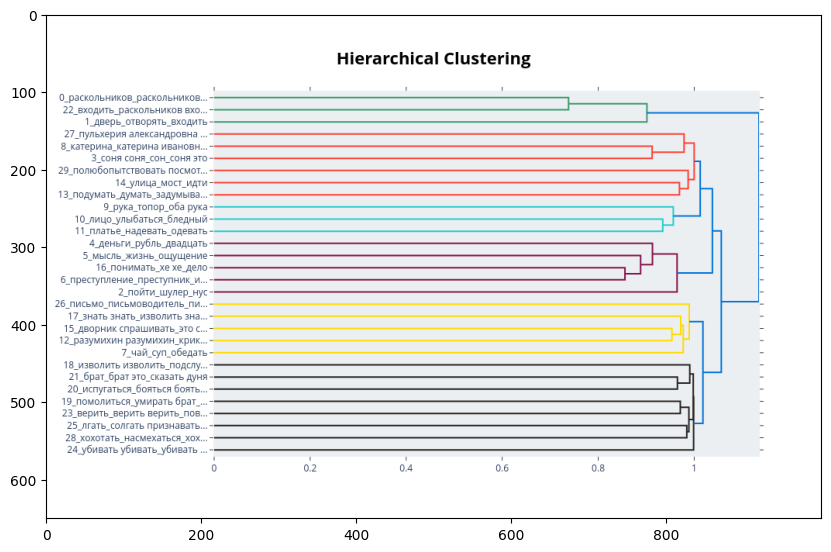

In [312]:
plt.figure(figsize = (10,10))
plt.imshow(Image.open('/kaggle/input/glowbytedataset/fig10.png'))
plt.show()

### Chebyshev distance

In [283]:
bscan_model = HDBSCAN(min_cluster_size=15, metric='chebyshev', cluster_selection_method='eom', prediction_data=True)

In [287]:
topic_model_chebyshev = BERTopic(embedding_model = embedding_model,
                       calculate_probabilities=True,
                       verbose=False,
                       min_topic_size = 15,
                       n_gram_range = (1,3),
                       representation_model=representation_model,
                       umap_model = umap_model,
                       hdbscan_model = bscan_model,
                      )

In [288]:
topics,probs = topic_model_chebyshev.fit_transform(df['clean_text'])

In [289]:
topic_model_chebyshev.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,4991,-1_мочь_сказать_дело_петрович,"[мочь, сказать, дело, петрович, разумихин, ива...","[весь это, это, это]"
1,0,459,0_раскольников_раскольник_раскольников расколь...,"[раскольников, раскольник, раскольников раскол...","[раскольников выходить, вскричать раскольников..."
2,1,290,1_преступление_мочь_право_факт,"[преступление, мочь, право, факт, убеждение, л...",[врать даваться это факт это мираж давайтек фа...
3,2,253,2_соня соня_сон_прошептать соня_вскрикивать соня,"[соня соня, сон, прошептать соня, вскрикивать ...","[соня молчать, прошептать соня, соня]"
4,3,231,3_деньги_рубль_двадцать_получать,"[деньги, рубль, двадцать, получать, билет, сто...","[деньги двадцать пять рубль, вопервых рубашка ..."
...,...,...,...,...,...
67,66,17,66_откланиваться выходить оставаться_отлучатьс...,"[откланиваться выходить оставаться, отлучаться...","[впрямь больной сказать повертываться уходить,..."
68,67,16,67_просыпаться_приходить допускать однажды_при...,"[просыпаться, приходить допускать однажды, при...",[тотчас бежать сюда четверть час честный слово...
69,68,16,68_катерина ивановна_амалия ивановна_раздражит...,"[катерина ивановна, амалия ивановна, раздражит...",[ибо хотя катерина ивановна преисполнять велик...
70,69,16,69_позвать тотчас вставать_приподымать встават...,"[позвать тотчас вставать, приподымать вставать...","[вставать, пойдемтек дворник пусть разбудить, ..."


In [318]:
#topic_model_chebyshev.visualize_topics()

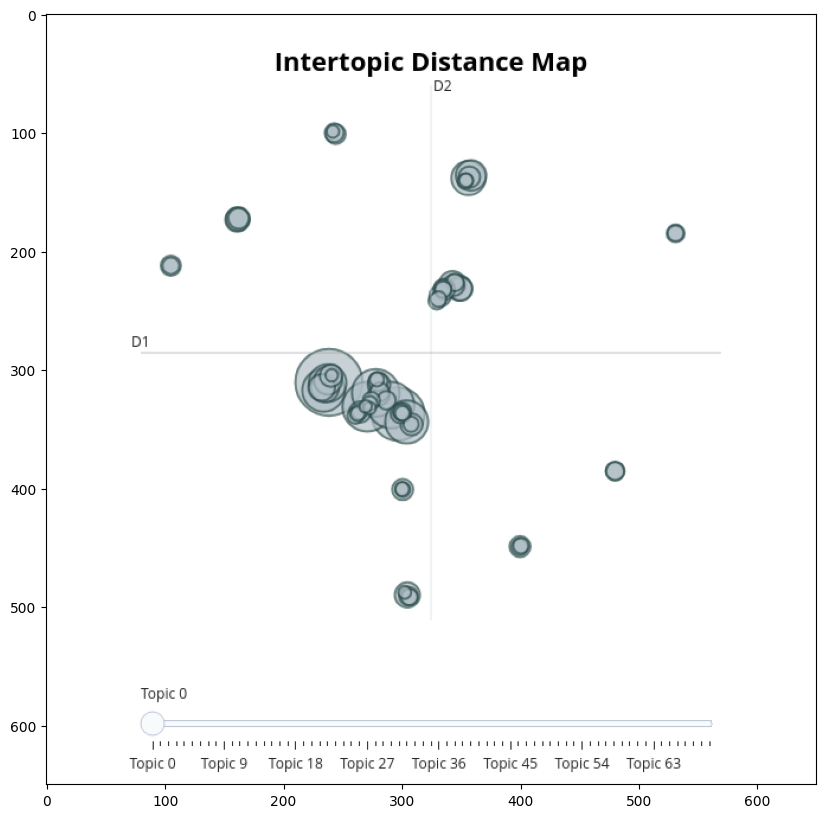

In [313]:
plt.figure(figsize = (10,10))
plt.imshow(Image.open('/kaggle/input/glowbytedataset/fig11.png'))
plt.show()

In [291]:
sim_matrix = cosine_similarity(topic_model_euclidian.topic_embeddings_, topic_model_chebyshev.topic_embeddings_)

In [292]:
topic = 4
topic_model_euclidian.get_topic(4)

[('преступление', 0.02013495607826599),
 ('право', 0.009068748577117137),
 ('убеждение', 0.0064214679344942556),
 ('преступник', 0.006241586386888272),
 ('закон', 0.005475269326480678),
 ('случай', 0.005169430996956822),
 ('обыск', 0.004989529033870682),
 ('дело', 0.004856855741726661),
 ('нравственный', 0.004562724438733898),
 ('совесть', 0.004322751173194931)]

In [293]:
most_similar_topic = np.argmax(sim_matrix[topic + 1])-1
most_similar_topic

1

In [294]:
topic_model_chebyshev.get_topic(most_similar_topic)

[('преступление', 0.010401651278428169),
 ('мочь', 0.010112264059051692),
 ('право', 0.007935810764604758),
 ('факт', 0.007496204992389818),
 ('убеждение', 0.0062460646939026376),
 ('лгать', 0.004747328264745173),
 ('слово', 0.004710246994767556),
 ('иметь право', 0.004617564362268302),
 ('смысл', 0.004243483172847589),
 ('случай', 0.0038427468416912846)]

In [317]:
#topic_model_chebyshev.visualize_barchart(top_n_topics=8)

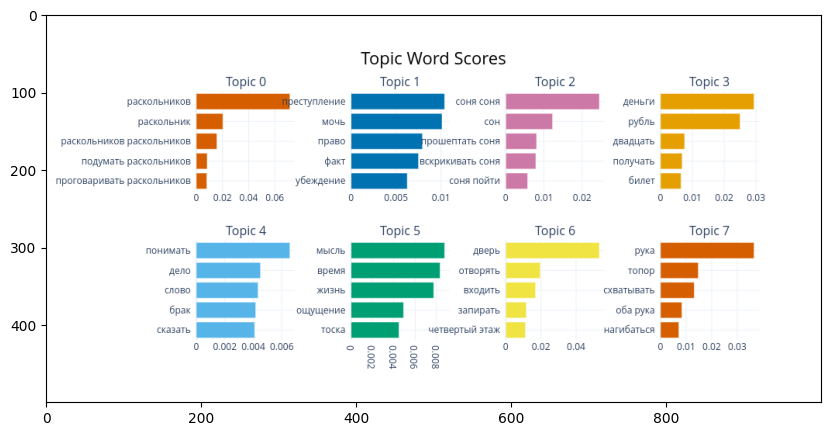

In [314]:
plt.figure(figsize = (10,10))
plt.imshow(Image.open('/kaggle/input/glowbytedataset/fig12.png'))
plt.show()

In [316]:
#topic_model_chebyshev.visualize_hierarchy(top_n_topics=30)

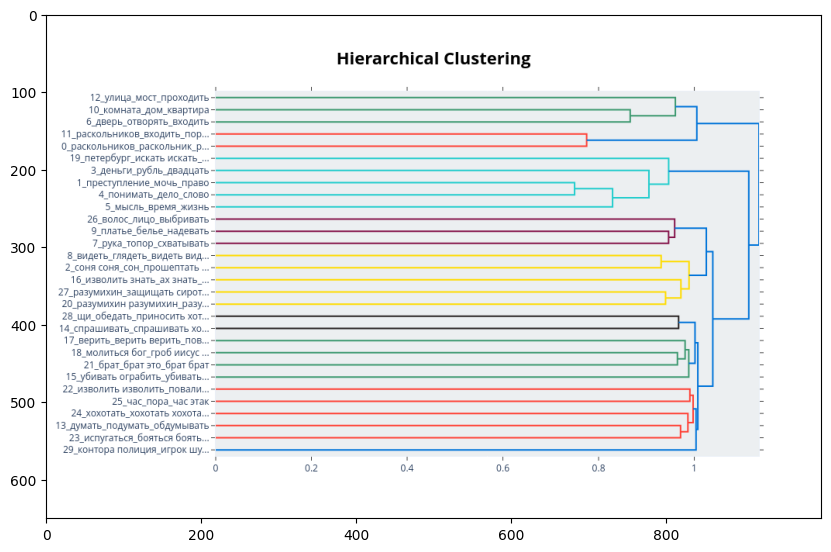

In [315]:
plt.figure(figsize = (10,10))
plt.imshow(Image.open('/kaggle/input/glowbytedataset/fig13.png'))
plt.show()

## Вывод

1. По результатам анализа можно выделать 5 основных тем : 
    * Раскольников и его перемещения
    * Мысли и ощущения
    * Быт
    * Семья
    * Преступление,испуг,лгать
2. Реализовано тематическое моделирование с помощью модели SberBert
3. По результатам используемых метрик можно сказать что, метрика Чебышева наиболее качественно разбивает на подтемы.Скорее всего причина в том, что метрика Чебышева более устойчиво к выбросам в данных.